In [1]:
import os
import time
import json
import pandas as pd
from gerbil_api_wrapper.gerbil import Gerbil

In [2]:
def read_json(filename):
    try:
        with open(filename) as f:
            return json.load(f)
    except Exception as e:
        print(str(e))
        return None
    
def write_json(data, filename):
    with open(filename, 'w') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)

def extract_string_qald(json_data, language):
    for question in json_data['question']:
        if question['language'] == language:
            return question['string']
        
standard_columns = ['system', 'dataset', 'language', 'id', 'experiment_url']

### Original

In [5]:
systems = ['deeppavlov']
datasets = ['qald10']
languages = ['en']

In [ ]:
for system in systems:
    for dataset in datasets:
        for language in languages:
            data = read_json(f"../original_data/original-{system}-{dataset}-{language}.json")

            for question in data:

                id_ = question["id"]

                answers_pred = question["answers_pred"]
                if type(answers_pred) == dict:
                    answers_pred_formatted = [{"x": {"type": "uri", "value": value}} for value in answers_pred['answer']]
                else:
                    answers_pred_formatted = []

                string = extract_string_qald(question, 'en') # here we use english question to get the string

                qald_template_true = {
                    "questions": [ question ]
                }

                qald_template_pred = {
                    "questions": [{
                        "id": f"{id_}",
                        "question": [{
                            "language": "en",
                            "string": string
                        }],
                        "query": {
                            "sparql": ""
                        },
                        "answers": [{
                            'head': {
                                    'vars': ['x']
                                    },
                            'results': {
                                'bindings': answers_pred_formatted
                            }
                        }]
                    }]
                }
                
                # check if the file exists
                if os.path.isfile(f"../original_data/{system}-{dataset}-{language}.log"):
                    df = pd.read_csv(f"../original_data/{system}-{dataset}-{language}.log", sep='\t')
                    if "id" not in df.columns:
                        df.columns = standard_columns
                    if id_ in df['id'].values: 
                        print(f"Skipping {id_}")
                        continue  # TODO: doesn't work for some reason CHECK!!!

                write_json(qald_template_true, f"../original_data/tmp/{system}-{dataset}-{id_}-{language}-true.json")
                write_json(qald_template_pred, f"../original_data/tmp/{system}-{dataset}-{id_}-{language}-pred.json")

                wrapper = Gerbil(
                    gold_standard_file=f"../original_data/tmp/{system}-{dataset}-{id_}-{language}-true.json",
                    test_results_file=f"../original_data/tmp/{system}-{dataset}-{id_}-{language}-pred.json",
                    test_results_name=f"{system}-{dataset}-{id_}-{language}-pred",
                    gold_standard_name=f"{system}-{dataset}-{id_}-{language}-true",
                    language=language,
                    # check_for_another_experiments=True
                )

                experiment_url = str(wrapper.get_experiment_url + wrapper.experiment_id)

                with open(f"../original_data/{system}-{dataset}-{language}.log", 'a') as f:
                    f.write(f"{system}\t{dataset}\t{language}\t{id_}\t{experiment_url}\n")
                
                time.sleep(0.1)

### Translations

In [3]:
system = 'deeppavlov'
dataset = 'qald9plustrain'
language = 'de'
kg = 'wikidata'

data_files = [file for file in os.listdir("../translated_data/") if system in file.lower() and dataset.replace('-', '') in file.lower() and f"{language}-" in file.lower() and ".log" not in file.lower() and kg in file.lower()]
data_files

['deeppavlov-QALD9PlusTrain-MT-Wikidata_de-davlan_ner-mag_el-nllb_plc_ft_mt.json.json',
 'deeppavlov-QALD9PlusTrain-MT-Wikidata_de-spacy_ner-mgenre_el-mbart_mt.json.json',
 'deeppavlov-QALD9PlusTrain-MT-Wikidata_de-babelscape_ner-mgenre_el-opus_mt.json.json',
 'deeppavlov-QALD9PlusTrain-MT-Wikidata_de-davlan_ner-mag_el-opus_plc_ft_mt.json.json',
 'deeppavlov-QALD9PlusTrain-MT-Wikidata_de-flair_ner-mgenre_el-nllb_mt.json.json',
 'deeppavlov-QALD9PlusTrain-MT-Wikidata_de-babelscape_ner-mag_el-mbart_mt.json.json',
 'deeppavlov-QALD9PlusTrain-MT-Wikidata_de-flair_ner-mag_el-libre_mt.json.json',
 'deeppavlov-QALD9PlusTrain-MT-Wikidata_de-babelscape_ner-mag_el-nllb_plc_ft_mt.json.json',
 'deeppavlov-QALD9PlusTrain-MT-Wikidata_de-spacy_ner-mgenre_el-opus_plc_ft_mt.json.json',
 'deeppavlov-QALD9PlusTrain-MT-Wikidata_de-flair_ner-mag_el-opus_mt.json.json',
 'deeppavlov-QALD9PlusTrain-MT-Wikidata_de-davlan_ner-mag_el-mbart_plc_ft_mt.json.json',
 'deeppavlov-QALD9PlusTrain-MT-Wikidata_de-flair_ne

In [4]:
for data_file in data_files:
    data = read_json(f"../translated_data/{data_file}")

    if not data:
        print(f"Error with {data_file}")
        assert False
    else:
        data = data['questions']
        
    for question in data:
        id_ = question["id"]

        answers_pred = question["answers_pred"]
        if type(answers_pred) == dict:
            answers_pred_formatted = [{"x": {"type": "uri", "value": value}} for value in answers_pred['answer']]
        else:
            answers_pred_formatted = []

        string = extract_string_qald(question, 'en') # here we use english question to get the string

        qald_template_true = {
            "questions": [ question ]
        }

        qald_template_pred = {
            "questions": [{
                "id": f"{id_}",
                "question": [{
                    "language": "en",
                    "string": string
                }],
                "query": {
                    "sparql": ""
                },
                "answers": [{
                    'head': {
                            'vars': ['x']
                            },
                    'results': {
                        'bindings': answers_pred_formatted
                    }
                }]
            }]
        }
        
        # check if the file exists
        if os.path.isfile(f"../translated_data/{data_file}.log"):
            df = pd.read_csv(f"../translated_data/{data_file}.log", sep='\t')
            if "id" not in df.columns:
                df.columns = standard_columns
            
            if str(id_) in df['id'].astype('str').values:
                print(f"Skipping {id_}")
                continue  

        write_json(qald_template_true, f"../translated_data/tmp/{data_file}-{id_}-true.json")
        write_json(qald_template_pred, f"../translated_data/tmp/{data_file}-{id_}-pred.json")

        wrapper = Gerbil(
            gold_standard_file=f"../translated_data/tmp/{data_file}-{id_}-true.json",
            test_results_file=f"../translated_data/tmp/{data_file}-{id_}-pred.json",
            test_results_name=f"{data_file}-{id_}-pred",
            gold_standard_name=f"{data_file}-{id_}-true",
            language=language,
            # check_for_another_experiments=True
        )

        experiment_url = str(wrapper.get_experiment_url + wrapper.experiment_id)

        with open(f"../translated_data/{data_file}.log", 'a') as f:
            f.write(f"{system}\t{dataset}\t{language}\t{id_}\t{experiment_url}\n")
        
        time.sleep(0.5)
        # TODO: produce error with upload URL 

2023-06-19 20:55:37,252 - 
Request to: https://gerbil-qa.aksw.org/gerbil/file/upload
Data: {'name': 'deeppavlov-QALD9PlusTrain-MT-Wikidata_de-davlan_ner-mag_el-nllb_plc_ft_mt.json.json-1-true', 'multiselect': None}
Files: {'file': ('deeppavlov-QALD9PlusTrain-MT-Wikidata_de-davlan_ner-mag_el-nllb_plc_ft_mt.json.json-1-true', <_io.BufferedReader name='../translated_data/tmp/deeppavlov-QALD9PlusTrain-MT-Wikidata_de-davlan_ner-mag_el-nllb_plc_ft_mt.json.json-1-true.json'>, 'application/json')}
2023-06-19 20:55:48,069 - Got response: {'files': [{'name': 'deeppavlov-QALD9PlusTrain-MT-Wikidata_de-davlan_ner-mag_el-nllb_plc_ft_mt.json.json-1-true', 'size': '626Kb', 'url': None, 'thumbnailUrl': None, 'deleteUrl': None, 'deleteType': None, 'error': None, 'fileType': 'application/json'}]} (200)
2023-06-19 20:55:48,072 - 
Request to: https://gerbil-qa.aksw.org/gerbil/file/upload
Data: {'name': 'deeppavlov-QALD9PlusTrain-MT-Wikidata_de-davlan_ner-mag_el-nllb_plc_ft_mt.json.json-1-pred', 'multiselec

## Parse results

In [5]:
metrics = [
    "macroF1",
    "microF1",
    "macroPrecision",
    "microPrecision",
    "macroRecall",
    "microRecall",
    "Macro_F1_QALD"
]

In [6]:
dir_path = "../translated_data/" # or "../translated_data/"
log_files = [file for file in os.listdir(dir_path) if ".log" in file] 

In [16]:
for log_file in log_files:
    if os.path.isfile(f"{dir_path}finished_experiments/{log_file}"):
        continue
    df = pd.read_csv(f"{dir_path}{log_file}", sep='\t', header=None)
    if df.shape[1] == len(standard_columns):
        df.columns = standard_columns
    elif df.shape[1] == len(standard_columns) + len(metrics):
        continue
    else:
        print("ERROR, check", log_file)
        continue
    
    print(log_file, ":", df.shape)

    id_jsonld = dict()

    for i, row in df.iterrows():
        error = False
        try:
            id_jsonld[row['id']] = Gerbil.get_results(row['experiment_url'])
        except:
            print(f"Error with {row['experximent_url']} in {log_file}")
            error = True
            continue
    for metric in metrics:
        try:
            if not error:
                df[metric] = df['id'].apply(lambda x: float(id_jsonld[x]['@graph'][1][metric]))
            else: 
                df[metric] = 0
        except:
            print(f"Error with {metric} in {log_file}")
            continue

    df.to_csv(f"{dir_path}{log_file}", sep='\t', index=False)

ERROR, check deeppavlov-QALD10Train-MT_de-davlan_ner-mag_el-libre_mt.json.json.log


## Determine finished experiments

In [ ]:
dir_path = "../translated_data/" # or "../translated_data/"
log_files = [file for file in os.listdir(dir_path) if ".log" in file] 

In [13]:
for log_file in log_files:
    df = pd.read_csv(f"{dir_path}{log_file}", sep='\t')
    if df.shape[1] == len(standard_columns) + len(metrics):
        pass
    else:
        print("ERROR, check", log_file)
        continue

    if df.macroF1.mean() > 0.0:
        df.to_csv(f"{dir_path}finished_experiments/{log_file}", sep='\t', index=False)


ERROR, check deeppavlov-QALD9PlusTrain-MT-Wikidata_de-babelscape_ner-mag_el-opus_mt.json.json.log
ERROR, check deeppavlov-QALD10Train-MT_de-spacy_ner-mgenre_el-nllb_mt.json.json.log
ERROR, check deeppavlov-QALD10Train-MT_de-davlan_ner-mag_el-libre_mt.json.json.log


## Compare results

In [81]:
system = 'deeppavlov'
dataset = 'qald-9-plus-test'
language = 'en'

df_dict = dict()

translated_path = "../translated_data/"
original_path = "../original_data/" 
log_files = [file for file in os.listdir(translated_path) if ".log" in file and system in file and dataset in file.lower() and f"{language}-" in file.lower()]  + [file for file in os.listdir(original_path) if ".log" in file and system in file and dataset in file.lower() and f"-{language}" in file.lower()]
original_log_files = [file for file in os.listdir(original_path) if ".log" in file and system in file and dataset in file.lower() and f"-{language}" in file.lower()]

In [82]:
for log_file in original_log_files:
    try:
        df = pd.read_csv(f"{translated_path}{log_file}", sep='\t')

        label = log_file.replace(".json.json.log", "")
        label = "".join(label.split("_")[1:]).replace(f"{language}-", "")
        df_dict[label] = df
    except:
        df = pd.read_csv(f"{original_path}{log_file}", sep='\t')

        label = log_file.replace(".log", "")
        df_dict[label] = df

In [83]:
df_stats = {"label": [], "macroF1": []}
for k, v in df_dict.items():
    df_stats["label"].append(k)
    df_stats["macroF1"].append(v["macroF1"].mean())

df_stats = pd.DataFrame(df_stats)

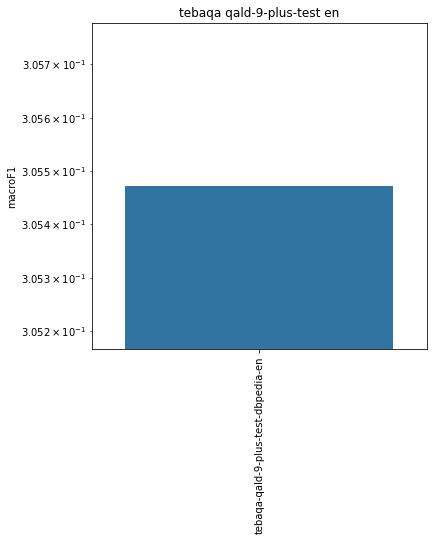

In [84]:
# create a bar chart where each bar is a system (log file)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# change figure size
plt.figure(figsize=(6, 6))
plt.yscale('log')
# rotate x-axis labels
plt.xticks(rotation=90)
# y ticks from 0 to 1 with 0.1 step
plt.yticks(np.arange(0, 1, 0.1))
ax = sns.barplot(data=df_stats.sort_values(by="macroF1"), x="label", y="macroF1")
# add labels and titles
ax.set(title=f"{system} {dataset} {language}", xlabel="", ylabel="macroF1")

# show the plot
plt.show()